In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

sns.set_style('darkgrid')

from statsmodels.tsa.arima_process import ArmaProcess, arma_acovf, arma_acf, arma_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acovf, acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit

import pmdarima as pm

## 1. Wstęp

Celem pracy nad znalezieniem modelu ARMA (Autoregressive Moving Average) dla danych dotyczących plam słonecznych (sunspots) jest opisanie, modelowanie oraz przewidywanie zmienności w czasie tego naturalnego zjawiska astronomicznego. Plamy słoneczne to ciemniejsze obszary na powierzchni Słońca, których liczba zmienia się cyklicznie w czasie i jest skorelowana z aktywnością słoneczną.

Analiza tych danych przy pomocy modelu ARMA pozwali na określenie, czy liczba plam słonecznych wykazuje wzorce sezonowe, cykliczne lub autokorelacje, które mogą być modelowane przez składniki autoregresji (AR) i średniej ruchomej (MA). Model ARMA dostarcza opisu matematycznego mechanizmów, które mogą wpływać na zmiany liczby plam słonecznych w czasie, uwzględniając zarówno przeszłe wartości (autoregresja), jak i błędy prognozy (średnia ruchoma). Ostatecznie zostanie ocenione, czy model ARMA jest wystarczający do uchwycenia struktury danych.

Dane pochodzą ze strony https://www.kaggle.com/datasets/robervalt/sunspots z Solar Influences Data Analysis Center, z wydziału fizyki Royal Observatory of Belgium. Zostały one udostępnione na prawach domeny publicznej. Zawierają one informacje o średniej miesięcznej liczbie plam słonecznych od 1749/01/01 do 2017/08/31.

3265


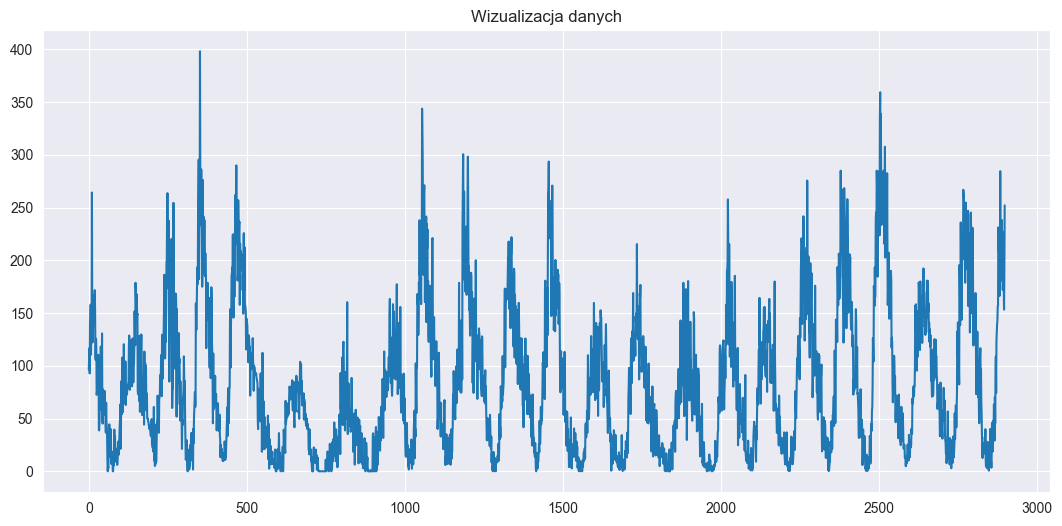

In [2]:
file_path = "Sunspots.csv"
df = pd.read_csv(file_path)

plt.figure(figsize=(13,6))
length=len(df['Monthly Mean Total Sunspot Number'])
X=df['Monthly Mean Total Sunspot Number'][:2900]
X_test=df['Monthly Mean Total Sunspot Number'][2900:]
plt.plot(X)
plt.title("Wizualizacja danych")
print(length)

Powyżej znajduję się wizualizacja danych. Długość próbki wynosi $3265$.

## 2. Przygotowanie danych do analizy

Początkowo sprawdzono jakość danych, a przede wszytskim czy znajdują się jakieś braki.

In [3]:
print(X.isnull().any().any())  # True, jeśli są braki


False


{'whiskers': [<matplotlib.lines.Line2D at 0x20a76b76f20>,
 'caps': [<matplotlib.lines.Line2D at 0x20a76b77460>,
 'boxes': [<matplotlib.lines.Line2D at 0x20a76b76c80>],
 'medians': [<matplotlib.lines.Line2D at 0x20a76b779a0>],
 'fliers': [<matplotlib.lines.Line2D at 0x20a76b77c40>],
 'means': []}

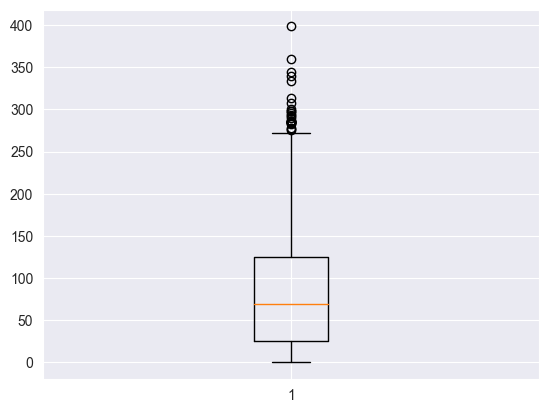

In [4]:
plt.boxplot(X)

Próbka nie zawiefra braków danych. W zbiorze znajdują się wartości odstające, w wszczególności takie, że są większe niż $Q3 + 1.5 * IQR$. Możliwe jednak, że taka jest charakterystyka danych, zatem próbki nie modyfikowano.

ten bozplot opisac


### Dekompozycja szeregu czasowego

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


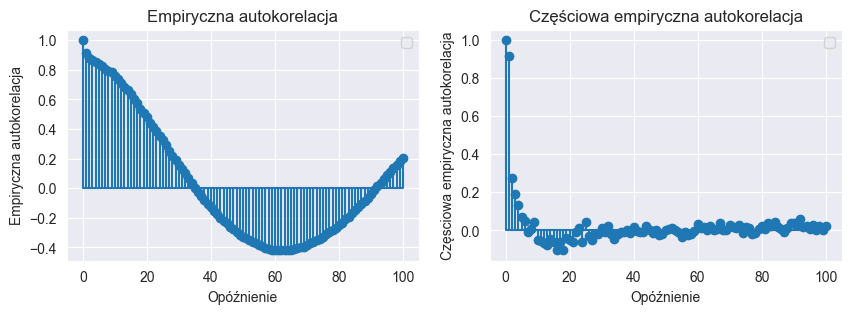

In [7]:
h_max = 100

plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
acf_emp = acf(X, fft=True, nlags=h_max)
plt.stem(acf_emp, basefmt='')
plt.xlabel('Opóźnienie')
plt.ylabel('Empiryczna autokorelacja')
plt.title('Empiryczna autokorelacja')
plt.legend()

plt.subplot(1, 2, 2)
acf_emp = pacf(X, nlags=h_max, method='yw')
plt.stem(acf_emp, basefmt='')
plt.xlabel('Opóźnienie')
plt.ylabel('Częsciowa empiryczna autokorelacja')
plt.title('Częściowa empiryczna autokorelacja')
plt.legend()

Powyżej znajdują się się wykresy empirycznej autokorelacij oraz częsciowej autokorelacji. Wykres autokorelacji  wskazuje na znaczną autokorelację dla niskich opóźnień, która powoli maleje w sposób sinusoidalny, a następnie przy wyższych opóźnieniach stopniowo oscyluje wokół zera. Takie zachowanie sugeruje, że dane mogą mieć charakter cykliczny lub sezonowy, co jest zgodne z oczekiwaniami, jeśli analizowane dane dotyczą plam słonecznych. Częściowa autokorelacja wykazuje znaczące wartości dla pierwszych kilku opóźnień, a następnie gwałtownie maleje i oscyluje wokół zera. Wyraźny pik na początkowych opóźnieniach sugeruje, że w danych dominuje proces autoregresyjny (AR). Rząd procesu AR można oszacować na podstawie liczby istotnych lagów na wykresie PACF.

### Periodogram

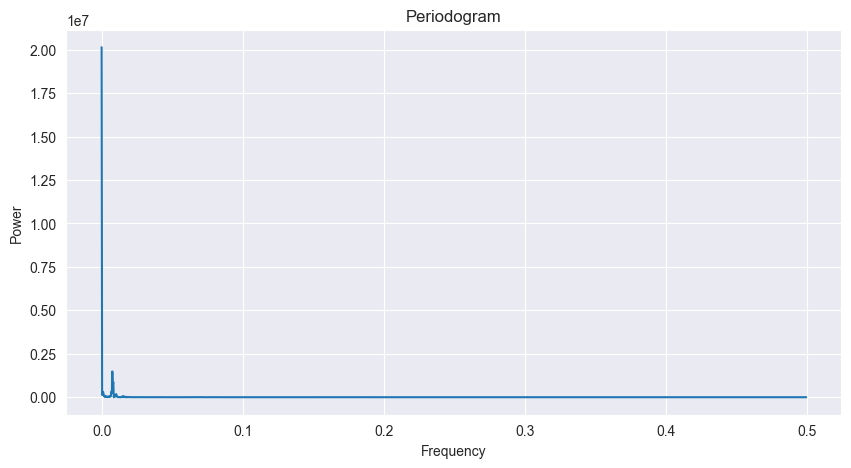

Top 5 Peaks (Frequency, Period):
Peak 1: 0.0000, inf
Peak 2: 0.0076, 131.82
Peak 3: -0.0076, -131.82
Peak 4: -0.0083, -120.83
Peak 5: 0.0083, 120.83
Peak 6: 0.0079, 126.09


C:\Users\User\AppData\Local\Temp\ipykernel_7696\2026184362.py:19: RuntimeWarning: divide by zero encountered in divide
  peaks_period = 1 / peaks_frequency


In [8]:
# Periodogram
ets_model = ExponentialSmoothing(X, seasonal_periods=130, trend='add', seasonal='add').fit()

trend_ets = ets_model.trend

periodogram = np.abs(np.fft.fft(X-trend_ets))**2 / len(X-trend_ets)
frequencies = np.fft.fftfreq(len(X-trend_ets))

plt.figure(figsize=(10, 5))
plt.plot(frequencies[:len(X-trend_ets) // 2], periodogram[:len(X-trend_ets) // 2])
plt.title('Periodogram')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.grid(True)
plt.show()

peak_indices = np.argsort(periodogram)[::-1][:6] 
peaks_frequency = frequencies[peak_indices]
peaks_period = 1 / peaks_frequency

print("Top 5 Peaks (Frequency, Period):")
for i in range(len(peaks_frequency)):
    print(f"Peak {i+1}: {peaks_frequency[i]:.4f}, {peaks_period[i]:.2f}")

Wykres periodogramu pomaga nas zindentyfikować, okres, czyli sezonowość pojawiającą się w naszej próbce. Drugi najwyższy peak odpowiada okresowi równemu $132$.

Następnie dokonano indetyfikację trendów deterministycznych, użyto do tego funckji `ExponentialSmoothing`. Na ostatnim wykresie przedstawione zostały dane po usunięciu komponentu trendowego i sezonowego.

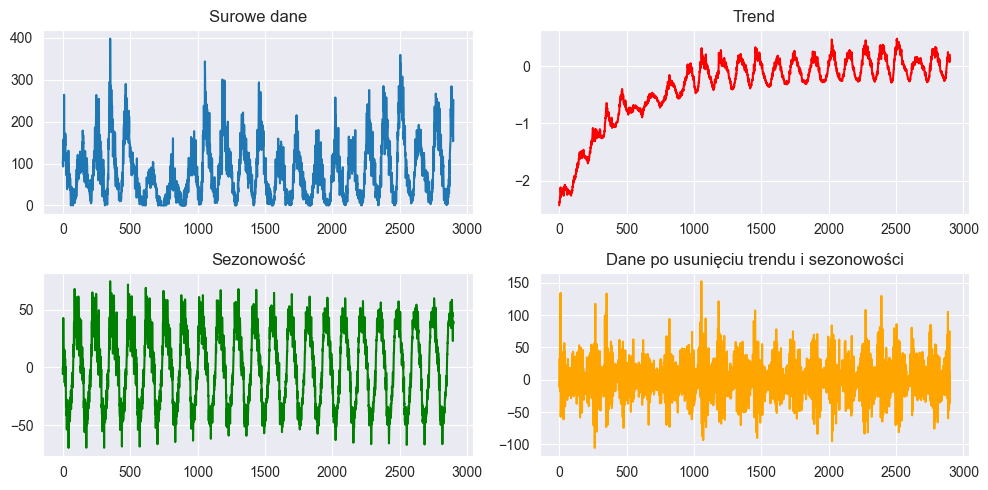

In [6]:
# https://otexts.com/fpp2/holt-winters.html

ets_model = ExponentialSmoothing(X, seasonal_periods=132, trend='add', seasonal='add').fit()

trend_ets = ets_model.trend
seasonal_ets = ets_model.season
residual_ets = ets_model.resid

plt.figure(figsize=(10, 5))

plt.subplot(2, 2, 1)
plt.plot(X, label='Original')
plt.title('Surowe dane')

plt.subplot(2, 2, 2)
plt.plot(trend_ets, label='Trend', color='red')
plt.title('Trend')

plt.subplot(2, 2, 3)
plt.plot(seasonal_ets, label='Seasonal', color='green')
plt.title('Sezonowość')

plt.subplot(2, 2, 4)
plt.plot(residual_ets, label='Residual', color='orange')
plt.title('Dane po usunięciu trendu i sezonowości')

plt.tight_layout()
plt.show()

Surowe dane mają wyraźny wzorzec cykliczny (sezonowy) o regularnych fluktuacjach.
Widoczne są również zmiany w amplitudzie, co może sugerować obecność trendu lub zmienność w czasie. Po dekompozycji widoczny jest trend malejący w pierwszej części szeregu czasowego, który następnie stabilizuje się. Sugeruje to, że dane zawierają długoterminowe zmiany, które mogą być związane z powolnymi zmianami w analizowanym procesie. Sezonowość jest wyraźnie widoczna i stabilna w czasie, co wskazuje na regularnie powtarzające się wzorce.Charakterystyka sezonowości (amplituda i częstotliwość) pozostaje względnie stała. Dane po odjęciu trendu i sezonowości wydają się być szeregiem z losowym rozkładem reszt. Mogą one być dalej modelowane za pomocą modelu ARMA.

Ostatecznie wykonano wykresu empirycznej autokorelacji i częściowej autokorelacji, dla surowych danych oraz dla danych po usunięciu komponentów deterministycznych.

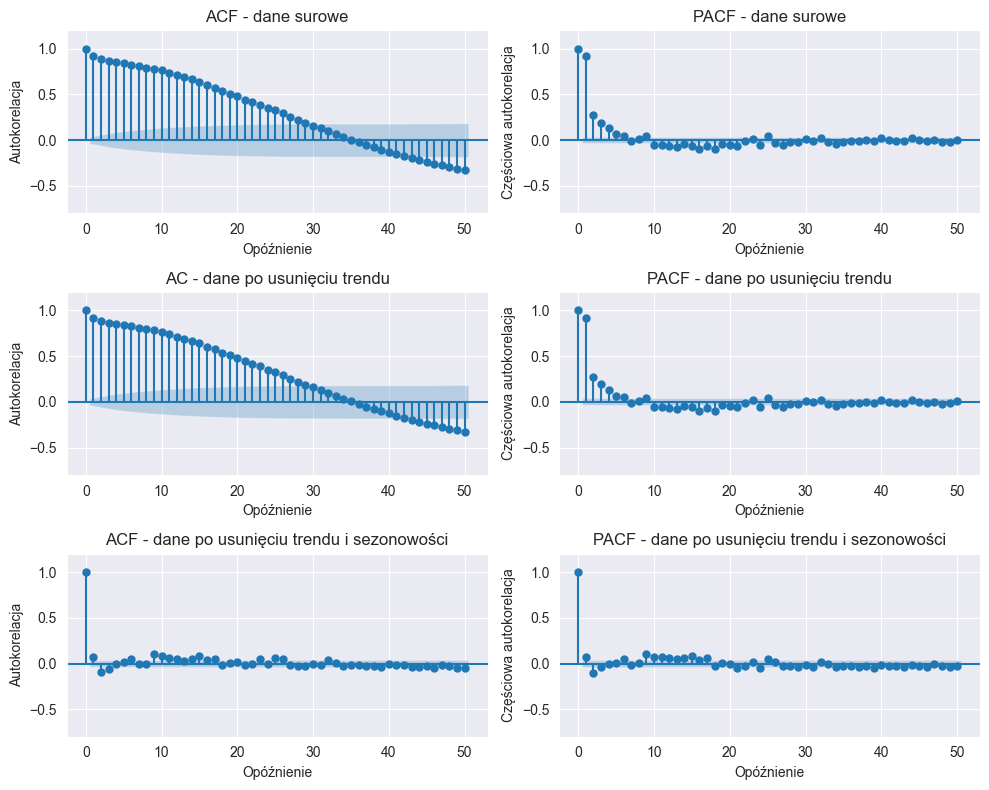

In [9]:
fig, axes = plt.subplots(3, 2, figsize=(10, 8))
h_max=50

plot_acf(X, lags=50, ax=axes[0, 0])
axes[0, 0].set_xlabel('Opóźnienie')
axes[0, 0].set_ylabel('Autokorelacja')
axes[0, 0].set_title('ACF - dane surowe')
axes[0, 0].set_ylim(-0.8, 1.2)

plot_pacf(X, lags=50, ax=axes[0, 1])
axes[0, 1].set_xlabel('Opóźnienie')
axes[0, 1].set_ylabel('Częściowa autokorelacja')
axes[0, 1].set_title('PACF - dane surowe')
axes[0, 1].set_ylim(-0.8, 1.2)

plot_acf(X-trend_ets, lags=50, ax=axes[1, 0])
axes[1, 0].set_xlabel('Opóźnienie')
axes[1, 0].set_ylabel('Autokorelacja')
axes[1, 0].set_title('AC - dane po usunięciu trendu')
axes[1, 0].set_ylim(-0.8, 1.2)

plot_pacf(X-trend_ets, lags=50, ax=axes[1, 1])
axes[1, 1].set_xlabel('Opóźnienie')
axes[1, 1].set_ylabel('Częściowa autokorelacja')
axes[1, 1].set_title('PACF - dane po usunięciu trendu')
axes[1, 1].set_ylim(-0.8, 1.2)

plot_acf(residual_ets, lags=50, ax=axes[2, 0])
#axes[2, 0].plot(acf_teor_, '-', label='Teoretyczna ACF')
axes[2, 0].set_xlabel('Opóźnienie')
axes[2, 0].set_ylabel('Autokorelacja')
axes[2, 0].set_title('ACF - dane po usunięciu trendu i sezonowości')
axes[2, 0].set_ylim(-0.8, 1.2)

plot_pacf(residual_ets, lags=50, ax=axes[2, 1])
#axes[2, 1].plot(pacf_teor_, '-', label='Teoretyczna PACF')
axes[2, 1].set_xlabel('Opóźnienie')
axes[2, 1].set_ylabel('Częściowa autokorelacja')
axes[2, 1].set_title('PACF - dane po usunięciu trendu i sezonowości')
axes[2, 1].set_ylim(-0.8, 1.2)

plt.tight_layout()
plt.show()

Po usunięciu trendów deterministycznych wykresy PACF, a w szczególności ACF zmieniły się. Dla danych po usunięciu determoinistucznych komponentów, autokorelacja ma dla wszytskich lagów wartość bliską 0 (oczywiście oprócz lagu 0). Podobnie stało się w przypadku PACF.

## 3. Modelowanie przy pomocy modelu ARMA

Za pomocą poniższego kodu dobrano najbardziej odpowiedni rząd modelu.

In [10]:
df = pd.DataFrame()

ps = []
qs = []
BIC = []
AIC = []
HQIC = []

max_p = 5
max_q = 5

for p in range(0, max_p):
    for q in range(0, max_q):
        
        # Dopasowanie modelu ARMA dla danego p i q
        model = ARIMA(residual_ets, order=(p, 0, q))
        model_fit = model.fit()
        
        # Zapisanie wartości p, q oraz wyników kryteriów informacyjnych
        ps.append(p)
        qs.append(q)
        AIC.append(model_fit.aic)
        BIC.append(model_fit.bic)
        HQIC.append(model_fit.hqic)

df['p']    = ps
df['q']    = qs
df['AIC']  = AIC
df['BIC']  = BIC
df['HQIC'] = HQIC

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting par

In [11]:
df.sort_values(by='AIC').head(1)


,p,q,AIC,BIC,HQIC
17,3,2,27195.992207,27237.799469,27211.056121


In [12]:
df.sort_values(by='BIC').head(1)


,p,q,AIC,BIC,HQIC
17,3,2,27195.992207,27237.799469,27211.056121


In [13]:
df.sort_values(by='HQIC').head(1)

,p,q,AIC,BIC,HQIC
17,3,2,27195.992207,27237.799469,27211.056121


Zarówno przy sortowaniu po BIC, jak i HQIC, wybierany jest ten sam zestaw parametrów: $p=3$, $q=2$.
Wartości AIC, BIC, HQIC dla tego modelu to:
* AIC: 27195.992207	
* BIC: 27237.799469	
* HQIC: 27211.056121

Model o parametrach $p=3$, $q=2$ jest najlepszy według kryteriów BIC i HQIC (czyli uzyskał najmniejsze wartości w obu przypadkach). Kryteria te służą do oceny jakości modelu z uwzględnieniem złożoności. Niższe wartości oznaczają lepszy kompromis między dopasowaniem a prostotą modelu.

Następnie za pomocą funckji `ARIMA` wyestymowano dwoma sposobami parametry modelu.

In [14]:
p, q = 3, 2

model = ARIMA(residual_ets, order=(p, 0, q)).fit(method='innovations_mle')

print("Wyniki:")
print(model.summary())

Wyniki:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2900
Model:                 ARIMA(3, 0, 2)   Log Likelihood              -13638.908
Date:                Tue, 28 Jan 2025   AIC                          27291.816
Time:                        19:42:06   BIC                          27333.624
Sample:                             0   HQIC                         27306.880
                               - 2900                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7339      0.492      1.491      0.136      -0.231       1.699
ar.L1          0.5735      0.483      1.188      0.235      -0.373       1.520
ar.L2         -0.4158      0.210     -1.984 

In [15]:
p, q = 3, 2

model_first_method = ARIMA(residual_ets, order=(p, 0, q)).fit(method='statespace')
model_second_method = ARIMA(residual_ets, order=(p, 0, q)).fit(method='innovations_mle')

print("Wyniki dla method='statespace':\n")
print(model_first_method.summary())
print("\n")
print("Wyniki dla method='innovations_mle':\n")
print(model_second_method.summary())

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Wyniki dla method='statespace':

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2900
Model:                 ARIMA(3, 0, 2)   Log Likelihood              -13590.996
Date:                Tue, 28 Jan 2025   AIC                          27195.992
Time:                        19:42:17   BIC                          27237.799
Sample:                             0   HQIC                         27211.056
                               - 2900                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8657      0.871      0.994      0.320      -0.841       2.573
ar.L1          1.8298      0.029     62.373      0.000       1.772       1.887
ar.L2         -1.01

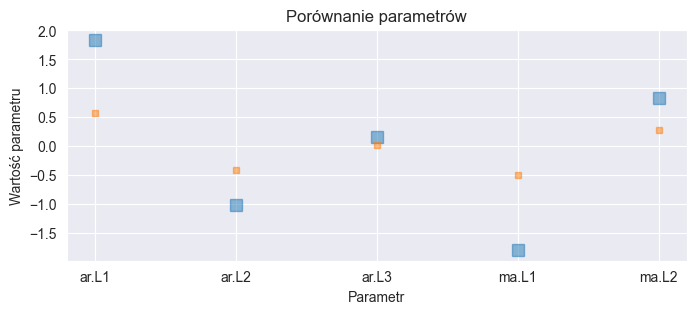

In [ ]:
plt.figure(figsize=(8,3))
plt.plot(model_first_method.params[1:-1], 's', markersize=8, alpha=0.5, label='Estymowana - metoda 1')
plt.plot(model_second_method.params[1:-1], 's', markersize=5, alpha=0.5, label='Estymowana - metoda 2')
plt.xlabel('Parametr')
plt.ylabel('Wartość parametru')
plt.title('Porównanie parametrów')

plt.show()

ktora wybrac???

## 4. Ocena dopasowania modelu

Aby ocenić dopasowanie modelu, użyto przedziałów ufności dla empirycznego wykresu autokorelacji i autokorelacji częściowej.

In [16]:
print(model.params)

const       0.733950
ar.L1       0.573548
ar.L2      -0.415758
ar.L3       0.020655
ma.L1      -0.505158
ma.L2       0.285328
sigma2    712.125995
dtype: float64


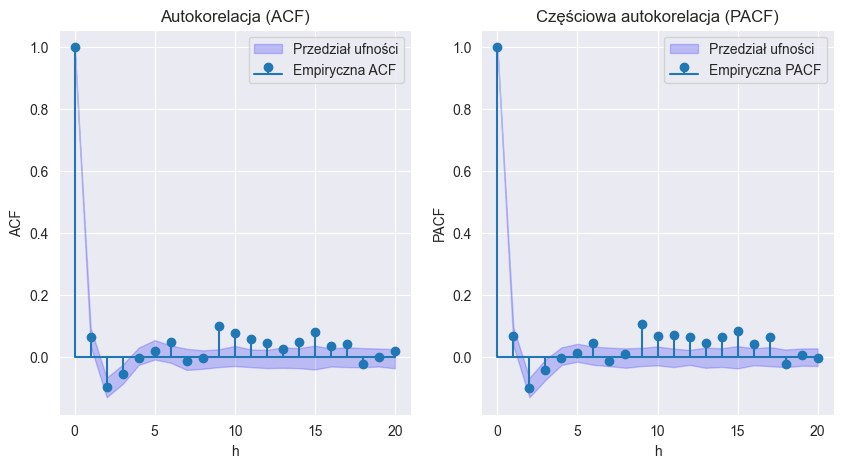

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import acf, pacf

n = 100
alfa = 0.05

wektor_h = list(range(21))
h_max = len(wektor_h) - 1

ar_coef = np.r_[1, -model.params[1:4]]  # AR zaczyna się od 1, odwrotność znaków
ma_coef = np.r_[1, model.params[4:6]]     # MA zaczyna się od 1
sigma_sq = np.sqrt(model.params[6])     # Skala to odchylenie standardowe

arma_process = ArmaProcess(ar_coef, ma_coef)


lista_acf = np.zeros((n, h_max + 1))
lista_pacf = np.zeros((n, h_max + 1))

for i in range(n):
    arma_process_trajectory = arma_process.generate_sample(nsample=len(X), scale=sigma_sq)
    lista_acf[i, :] = acf(arma_process_trajectory, fft=True, nlags=h_max)
    lista_pacf[i, :] = pacf(arma_process_trajectory, nlags=h_max, method='yw')

# Wyznaczanie przedziałów kwantylowych
lower_acf = np.quantile(lista_acf, alfa, axis=0)
upper_acf = np.quantile(lista_acf, 1 - alfa, axis=0)

lower_pacf = np.quantile(lista_pacf, alfa, axis=0)
upper_pacf = np.quantile(lista_pacf, 1 - alfa, axis=0)

# Empiryczne ACF i PACF
acf_emp = acf(residual_ets, fft=True, nlags=h_max)
# pacf_emp = pacf(X, nlags=h_max, method='yw')
pacf_emp = pacf(residual_ets, nlags=h_max, method='yw')


plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.stem(wektor_h, acf_emp, basefmt='', label='Empiryczna ACF')
plt.fill_between(wektor_h, lower_acf, upper_acf, color="blue", alpha=0.2, label='Przedział ufności')
plt.xlabel("h")
plt.ylabel("ACF")
plt.title("Autokorelacja (ACF)")
plt.legend()

plt.subplot(1,2,2)
plt.stem(wektor_h, pacf_emp, basefmt='', label='Empiryczna PACF')
plt.fill_between(wektor_h, lower_pacf, upper_pacf, color="blue", alpha=0.2, label='Przedział ufności')
plt.xlabel("h")
plt.ylabel("PACF")
plt.title("Częściowa autokorelacja (PACF)")
plt.legend()
plt.show()



Empiryczne wykresy pokrywają się z przedziałami ufności na poziomie 95%, większe odchylenia obserwuje się w opóźnieniu równym 10. Może to być kolejny dowód na poprawne dopasowanie modelu.

Dodatkowo wykonano porównanie danych z liniami kwantylowymi.

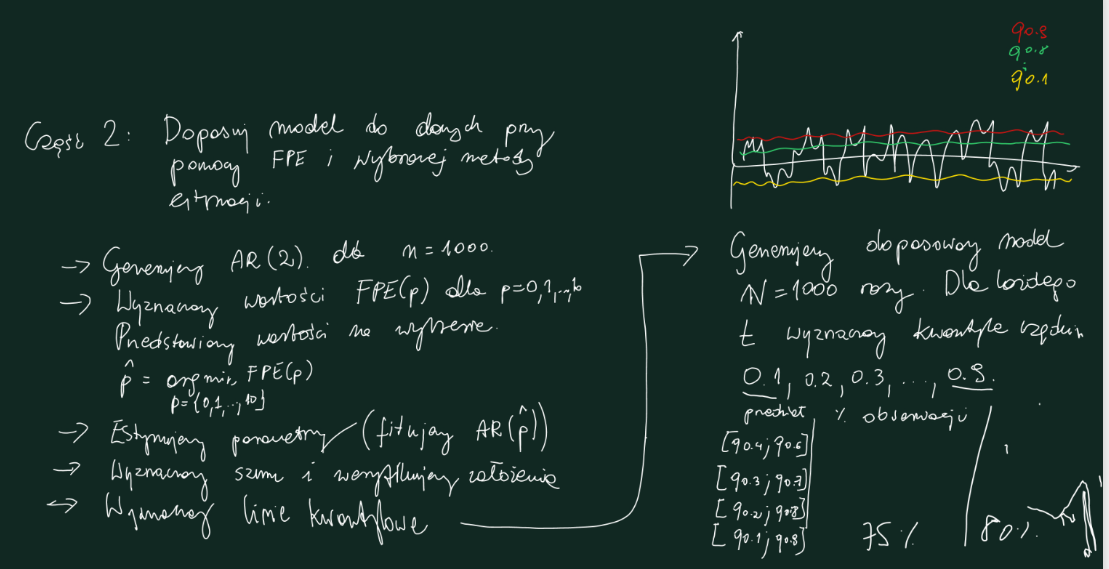

Procentowy udział residual_ets między liniami kwantylowymi:
           Procentowy udział
0.10-0.35          24.793103
0.10-0.60          53.896552
0.10-0.85          78.206897
0.35-0.60          29.103448
0.35-0.85          53.413793
0.60-0.85          24.310345


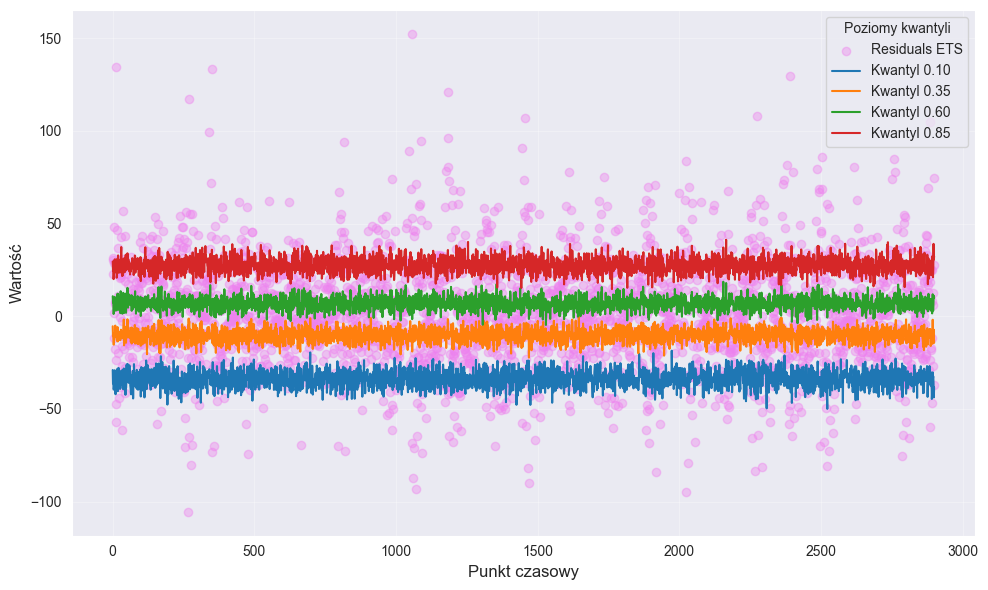

In [61]:


# Parametry modelu ARMA(3,2)
ar_coef = np.r_[1, -model.params[1:4]]  # Współczynniki AR
ma_coef = np.r_[1, model.params[4:6]]   # Współczynniki MA
sigma_sq = np.sqrt(model.params[6])     # Odchylenie standardowe reszt

# Parametry symulacji
N = 100  # Liczba symulacji
n_obs = len(residual_ets)  # Liczba obserwacji
quantile_levels = np.arange(0.1, 1, 0.25)  # Poziomy kwantyli (0.1, 0.25, ..., 0.9)

# Proces ARMA
arma_process = ArmaProcess(ar_coef, ma_coef)

# Tablica do przechowywania wyników kwantyli
quantiles_matrix = np.zeros((len(quantile_levels), n_obs))

# Generowanie symulacji
simulations = np.zeros((N, n_obs))  # Przechowywanie symulacji

for i in range(N):
    simulations[i] = arma_process.generate_sample(nsample=n_obs, scale=sigma_sq)

# Wyznaczanie kwantyli
for q, h in enumerate(quantile_levels):
    for t in range(n_obs):  # Dla każdego punktu czasowego
        quantiles_matrix[q, t] = np.quantile(simulations[:, t], h)

# Liczenie procentowego udziału residual_ets między wszystkimi parami kwantyli
num_quantile_pairs = len(quantile_levels) * (len(quantile_levels) - 1) // 2  # Wszystkie możliwe pary
percent_between_quantiles = np.zeros((num_quantile_pairs, n_obs))

quantile_pairs = []
pair_index = 0

for i in range(len(quantile_levels)):
    for j in range(i + 1, len(quantile_levels)):  # Kombinacje par kwantyli
        quantile_pairs.append((quantile_levels[i], quantile_levels[j]))
        lower_bound = quantiles_matrix[i]
        upper_bound = quantiles_matrix[j]

        for t in range(n_obs):
            count_between = np.sum((residual_ets[t] >= lower_bound[t]) & (residual_ets[t] < upper_bound[t]))
            percent_between_quantiles[pair_index, t] = count_between  # Liczba residuals ETS
        pair_index += 1

# Sumaryczny procent między przedziałami kwantyli
total_percent_per_quantile = np.sum(percent_between_quantiles, axis=1) / n_obs * 100

# Przedstawienie wyników w tabelce
df_percent = pd.DataFrame(
    total_percent_per_quantile,
    index=[f'{pair[0]:.2f}-{pair[1]:.2f}' for pair in quantile_pairs],
    columns=["Procentowy udział"]
)

print("Procentowy udział residual_ets między liniami kwantylowymi:")
print(df_percent)

# Wizualizacja kwantyli i punktów
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(n_obs), residual_ets, color='violet', alpha=0.4, label="Residuals ETS")
for q, h in enumerate(quantile_levels):
    plt.plot(range(n_obs), quantiles_matrix[q], label=f'Kwantyl {h:.2f}')

plt.xlabel('Punkt czasowy', fontsize=12)
plt.ylabel('Wartość', fontsize=12)
plt.legend(title="Poziomy kwantyli", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


* prognoza  - POMIJAMY CHYBA


In [25]:
def func2(wektor_t,b_1,b_2,b_3):
    return b_1*np.sin(b_2*wektor_t)+b_3
n=len(X)
wektor_t=np.linspace(0,n,n)
popt, pcov = curve_fit(func2,wektor_t,seasonal_ets,p0=[100,30,0])
b1_hat,b2_hat, b3_hat=popt
X_3=seasonal_ets-b1_hat*np.sin(wektor_t*b2_hat)-b3_hat

In [26]:
def func1(wektor_t,a_1,a_2,a_3):
    return a_1*np.log(wektor_t)+a_3

n=len(X)
wektor_t=np.linspace(1,n,n)
popt, pcov = curve_fit(func1,wektor_t,trend_ets)
a1_hat,a2_hat, a3_hat=popt
X_2=trend_ets-a1_hat*np.log(wektor_t)-a3_hat

c:\Users\dbjd2\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Text(0.5, 1.0, 'dane X')

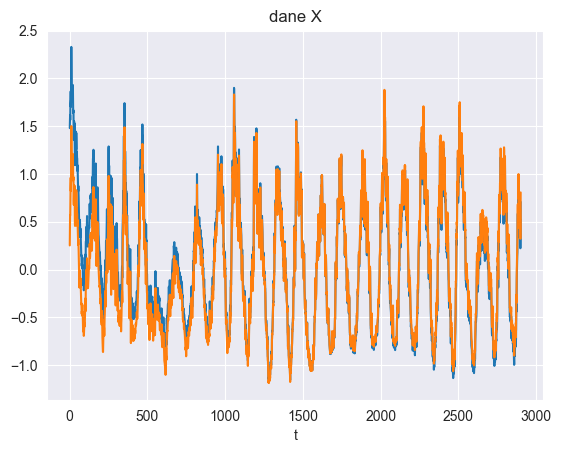

In [27]:
plt.plot(wektor_t,trend_ets)
plt.plot(wektor_t,X_2)
plt.xlabel('t')
plt.title('dane X')

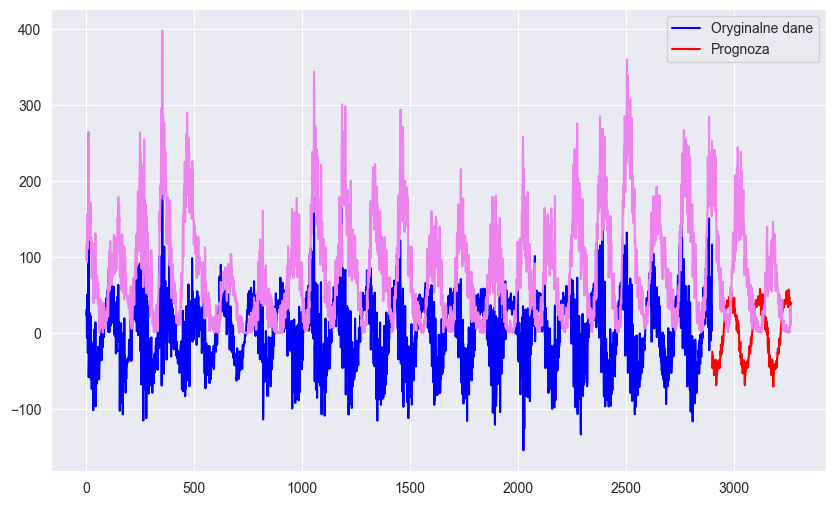

In [28]:

# 2. Dopasowanie modelu ARMA(1,2) do komponentu resztowego
arma_model = ARIMA(residual_ets.dropna(), order=(1, 0, 2))  # d=0, bo modelujesz resztę
arma_fit = arma_model.fit()

n_steps = len(X_test) # Liczba kroków do prognozy
residual_forecast = arma_fit.forecast(steps=n_steps)


future_trend = trend_ets[-n_steps:]  # Ekstrapolacja trendu (lub dopasowanie)
future_seasonal = seasonal_ets[-n_steps:]  # Powtórzenie sezonowości (lub odpowiednia predykcja)

final_forecast = future_trend.values + future_seasonal.values + residual_forecast

plt.figure(figsize=(10, 6))
plt.plot(trend_ets + seasonal_ets + residual_ets, label='Oryginalne dane', color='blue')
plt.plot(final_forecast, label='Prognoza', color='red')
plt.plot(X_test,color='violet')
plt.plot(X,color='violet')
plt.legend()
plt.show()


## 5. Weryfikacja założeń szumu

Aby zweryfikować założenia szumu, wyznaczymy residua na podstawie dopasowanego modelu i sprawdzimy ich zachowania.
Założenia szumu są następujące:
* residua są nieskorelowane,
* residua mają wartość oczekiwaną równą 0,
* residua mają stałą wartość wariancji,
* (dodatkowe) residua mają ten sam rozkład, w szczególności rozkład normalny.

* średnia

Średnia: 0.0021398150977376944


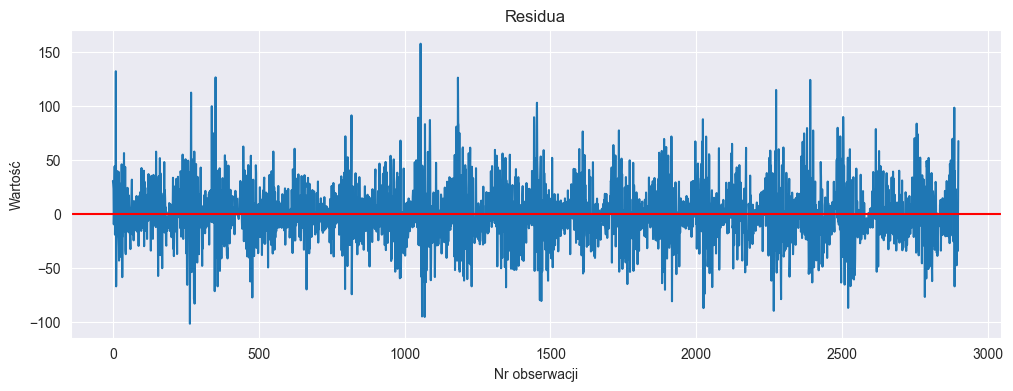

In [25]:
resid_normal =model.resid
print("Średnia:",np.mean(resid_normal))

plt.figure(figsize=(12, 4))
plt.plot(resid_normal)
plt.title('Residua')
plt.xlabel('Nr obserwacji')
plt.ylabel('Wartość')
plt.axhline(y=0,color='red')
plt.show()

* wariancja 

In [26]:
import numpy as np
from scipy.stats import levene

groups = np.array_split(resid_normal, 3)

# Wykonaj test Levene'a
stat, p_value = levene(*groups)

print("Levene's test statistic:", stat)
print("p-value:", p_value)

if p_value < 0.01:
    print("Odrzucamy hipotezę zerową: wariancje nie są równe.")
else:
    print("Nie odrzucamy hipotezy zerowej: wariancje są równe.")


Levene's test statistic: 5.988798823933741
p-value: 0.002537813111146166
Odrzucamy hipotezę zerową: wariancje nie są równe.


Do sprawdzenia stałości wariancji wykorzystano test jednorodności wariancji Levene`a. 

*Def*. Test Levene'a (jednorodności wariancji): Dla każdej zmiennej zależnej wykonywana jest analiza wariancji wartości bezwzględnych odchyleń od średniej w odpowiedniej grupie. Jeżeli test Levene'a daje wynik statystycznie istotny, to należy odrzucić hipotezę o jednorodności wariancji.

Z powyższego testu statystycznego, wynika, że wariancja nie jest wartością stałą dla residuów.

* niezależność

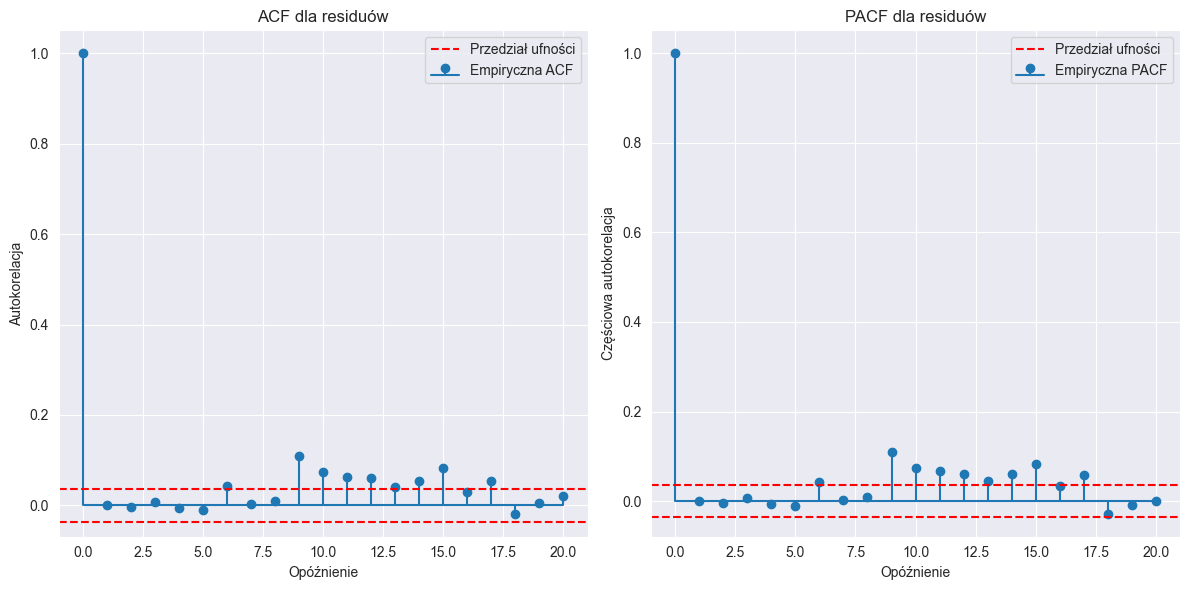

In [27]:

from scipy.stats import norm 

N = len(resid_normal)

acf_emp = acf(resid_normal, fft=True, nlags=h_max)
acf_emp_t = pacf(resid_normal, nlags=h_max, method='yw')

alpha = 0.05
lower_quantile = norm.ppf(alpha / 2) 
upper_quantile = norm.ppf(1 - alpha / 2) 

conf_int_acf = upper_quantile / np.sqrt(N)  
conf_int_pacf = upper_quantile / np.sqrt(N) 

# Wykresy
plt.figure(figsize=(12, 6))

# Wykres ACF
plt.subplot(1, 2, 1)
plt.stem(range(len(acf_emp)), acf_emp, basefmt='', label='Empiryczna ACF')
plt.axhline(y=conf_int_acf, color='r', linestyle='--', label='Przedział ufności')
plt.axhline(y=-conf_int_acf, color='r', linestyle='--')
plt.xlabel('Opóźnienie')
plt.ylabel('Autokorelacja')
plt.title('ACF dla residuów')
plt.legend()

# Wykres PACF
plt.subplot(1, 2, 2)
plt.stem(range(len(acf_emp_t)), acf_emp_t, basefmt='', label='Empiryczna PACF')
plt.axhline(y=conf_int_pacf, color='r', linestyle='--', label='Przedział ufności')
plt.axhline(y=-conf_int_pacf, color='r', linestyle='--')
plt.xlabel('Opóźnienie')
plt.ylabel('Częściowa autokorelacja')
plt.title('PACF dla residuów')
plt.legend()

plt.tight_layout()
plt.show()



Na wykresie ACF widzimy, że większość punktów (poza opóźnieniem 0) znajduje się w granicach przedziału ufności (czerwone przerywane linie). To sugeruje, że autokorelacje na dalszych opóźnieniach są bliskie zeru i brak jest istotnych powiązań między kolejnymi wartościami residuów.

Podobnie jak w przypadku ACF, na wykresie PACF także niemal wszystkie wartości (poza opóźnieniem 0) mieszczą się w przedziale ufności. Oznacza to brak istotnych częściowych autokorelacji.
 
Residua można uznać za *niezależne*, ponieważ nie ma dowodów na występowanie znaczącej autokorelacji (zarówno w ACF, jak i w PACF).


* normalność rozkładu

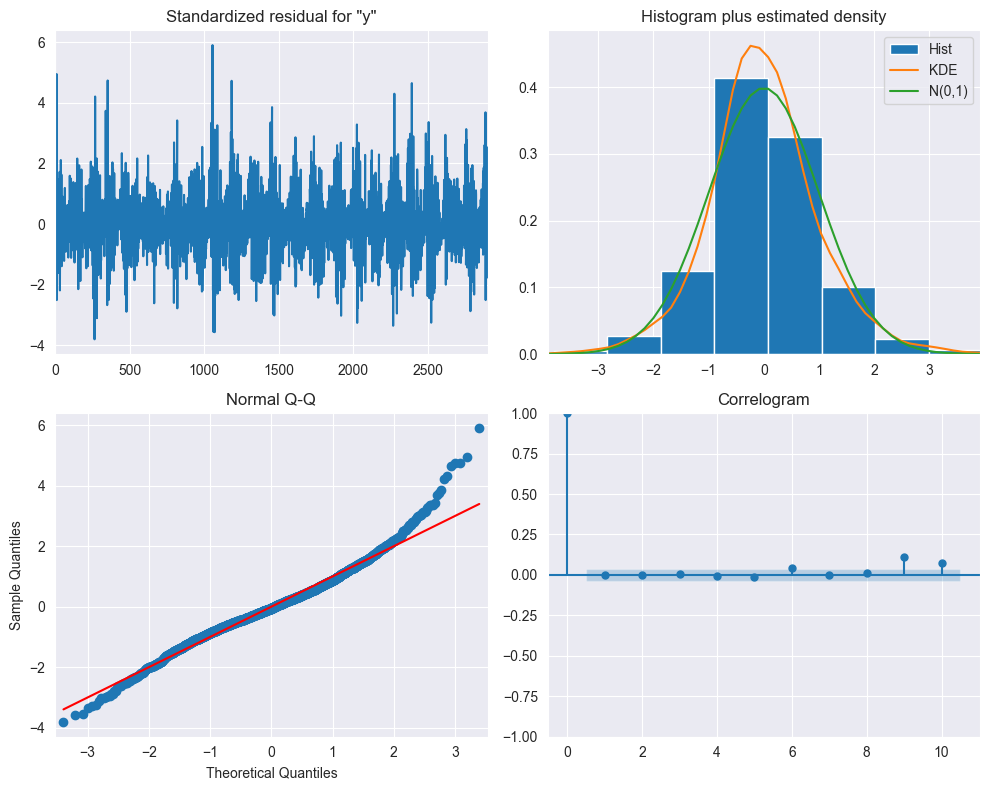

In [28]:
model.plot_diagnostics(figsize=(10, 8))
plt.tight_layout()
plt.show()

Z powyższych wykresów, nietrudno zauważyć, że residua modelu mają rozkład zbliżony do normalnego. Jednak na Q-Q plotcie, widać wartości odstające. Zatem dopasowano do danych rozkład t-Studenta i oszacowano parametry.

Oszacowane parametry: df=5.42, loc=-0.75, scale=21.40


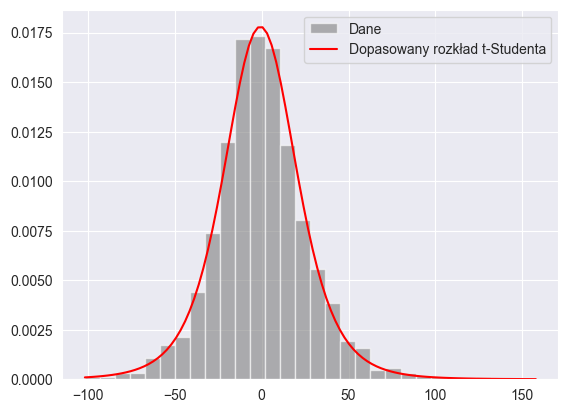

In [33]:
from scipy.stats import t,kstest

# Przygotowanie danych
data = resid_normal  # Twoje dane

# Dopasowanie rozkładu t-Studenta
params = t.fit(data)  # Oszacowanie parametrów: df, loc, scale
print(f"Oszacowane parametry: df={params[0]:.2f}, loc={params[1]:.2f}, scale={params[2]:.2f}")

x = np.linspace(min(data), max(data), 100)
pdf = t.pdf(x, *params)  # Funkcja gęstości dopasowanego rozkładu

plt.hist(data, bins=30, density=True, alpha=0.6, color='gray', label="Dane")
plt.plot(x, pdf, 'r-', label="Dopasowany rozkład t-Studenta")
plt.legend()
plt.show()


Rozkład t-Studenta zdecydowanie lepiej opisuje residua, niż rozkład normalny.

## 6. Wnioski